# Klasifikasi Sampah - Interactive Image Scanner

This notebook allows you to upload waste images and detect objects using the trained YOLOv8 model.

## Features
- Upload images via file widget
- Real-time object detection
- Visual bounding boxes with class labels
- Confidence scores for each detection

## Requirements
- Trained model at `./models/best.pt`
- All dependencies installed (see requirements.txt)

In [1]:
# Import required libraries
import io
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from PIL import Image
from IPython.display import display
from ultralytics import YOLO

print("✓ All libraries loaded successfully")

✓ All libraries loaded successfully


In [2]:
# Verify notebook location and model path
import os
from pathlib import Path

print("📂 Current working directory:", os.getcwd())
print("📁 Notebook directory:", Path(__file__).parent if '__file__' in globals() else Path.cwd())

# Check if model exists
model_path_option1 = Path('./models/best.pt')
model_path_option2 = Path('../models/best.pt')

print("\n🔍 Checking model paths:")
print(f"  Option 1 (./models/best.pt): {model_path_option1.exists()} → {model_path_option1.resolve()}")
print(f"  Option 2 (../models/best.pt): {model_path_option2.exists()} → {model_path_option2.resolve()}")

if model_path_option2.exists():
    print("\n✓ Use '../models/best.pt' (relative to notebooks/ directory)")
elif model_path_option1.exists():
    print("\n✓ Use './models/best.pt' (already in project root)")
else:
    print("\n❌ Model not found! Train the model first with: python train.py")

📂 Current working directory: /home/remus/Development/Python/Klasifikasi_Sampah/notebooks
📁 Notebook directory: /home/remus/Development/Python/Klasifikasi_Sampah/notebooks

🔍 Checking model paths:
  Option 1 (./models/best.pt): False → /home/remus/Development/Python/Klasifikasi_Sampah/notebooks/models/best.pt
  Option 2 (../models/best.pt): True → /home/remus/Development/Python/Klasifikasi_Sampah/models/20251105_024145_best.pt

✓ Use '../models/best.pt' (relative to notebooks/ directory)


In [3]:
# Load trained YOLO model
# Path relative to notebook location (notebooks/ directory)
MODEL_PATH = '../models/best.pt'

if not Path(MODEL_PATH).exists():
    print(f"❌ Model not found: {MODEL_PATH}")
    print(f"   Looking at absolute path: {Path(MODEL_PATH).resolve()}")
    print("Please train a model first using train.py")
    model = None
else:
    try:
        model = YOLO(MODEL_PATH)
        print(f"✓ Model loaded successfully from {MODEL_PATH}")
        print(f"  Classes: {model.names}")
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        model = None

✓ Model loaded successfully from ../models/best.pt
  Classes: {0: 'plastic', 1: 'metal', 2: 'glass', 3: 'paper', 4: 'cardboard', 5: 'other'}


In [5]:
# Create file upload widget
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

print("📁 Upload an image using the widget below:")
display(uploader)

📁 Upload an image using the widget below:


FileUpload(value=(), accept='image/*', description='Upload Image')

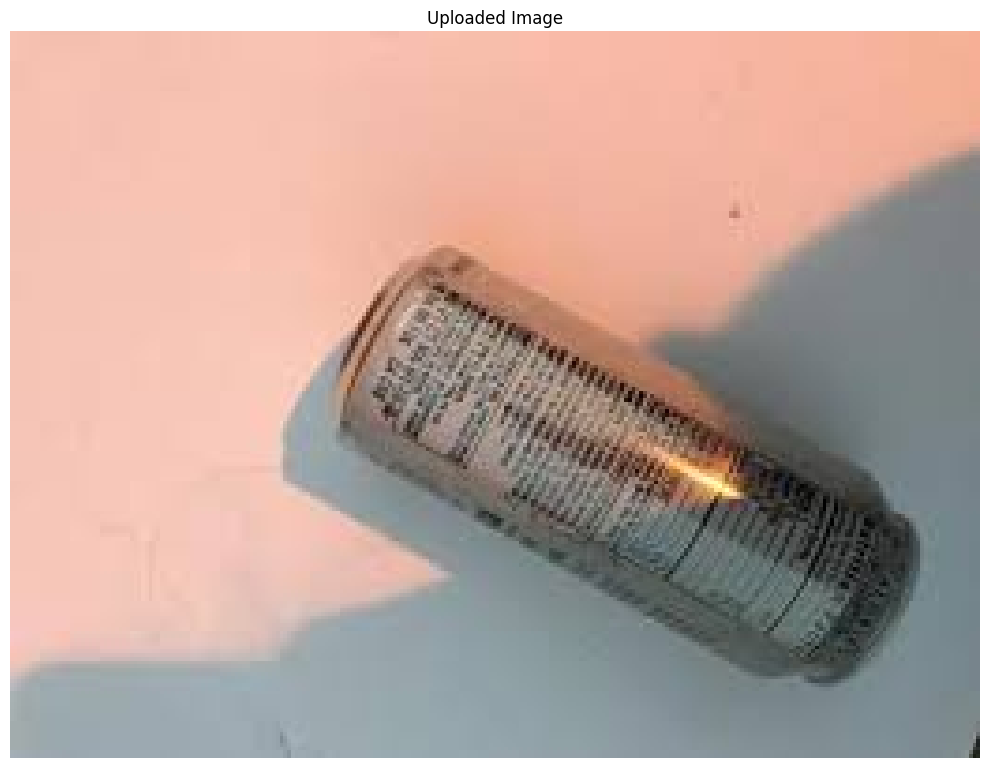

In [8]:
# Display uploaded image
def display_image(uploaded_file):
    """Display the uploaded image."""
    if not uploaded_file:
        print("No image uploaded yet")
        return None
    
    # Get uploaded file data
    # uploader.value is a tuple of FileUpload objects
    if isinstance(uploaded_file, tuple) and len(uploaded_file) > 0:
        file_info = uploaded_file[0]
        image_data = file_info['content']
    elif isinstance(uploaded_file, dict):
        # Handle dict format (older ipywidgets versions)
        file_info = list(uploaded_file.values())[0]
        image_data = file_info['content']
    else:
        print("Invalid file format")
        return None
    
    # Open image
    image = Image.open(io.BytesIO(image_data))
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('Uploaded Image')
    plt.tight_layout()
    plt.show()
    
    return image

# Display uploaded image
uploaded_image = display_image(uploader.value)

In [9]:
# Run detection on uploaded image
def run_detection(image, confidence_threshold=0.25):
    """Run YOLO detection on image and return results."""
    if model is None:
        print("❌ Model not loaded. Please load model first.")
        return None
    
    if image is None:
        print("❌ No image provided. Upload an image first.")
        return None
    
    print("🔍 Running detection...")
    
    # Run inference
    results = model(image, conf=confidence_threshold, verbose=False)
    
    print(f"✓ Detection complete")
    
    return results

# Run detection
detection_results = run_detection(uploaded_image, confidence_threshold=0.25)

🔍 Running detection...
✓ Detection complete
✓ Detection complete


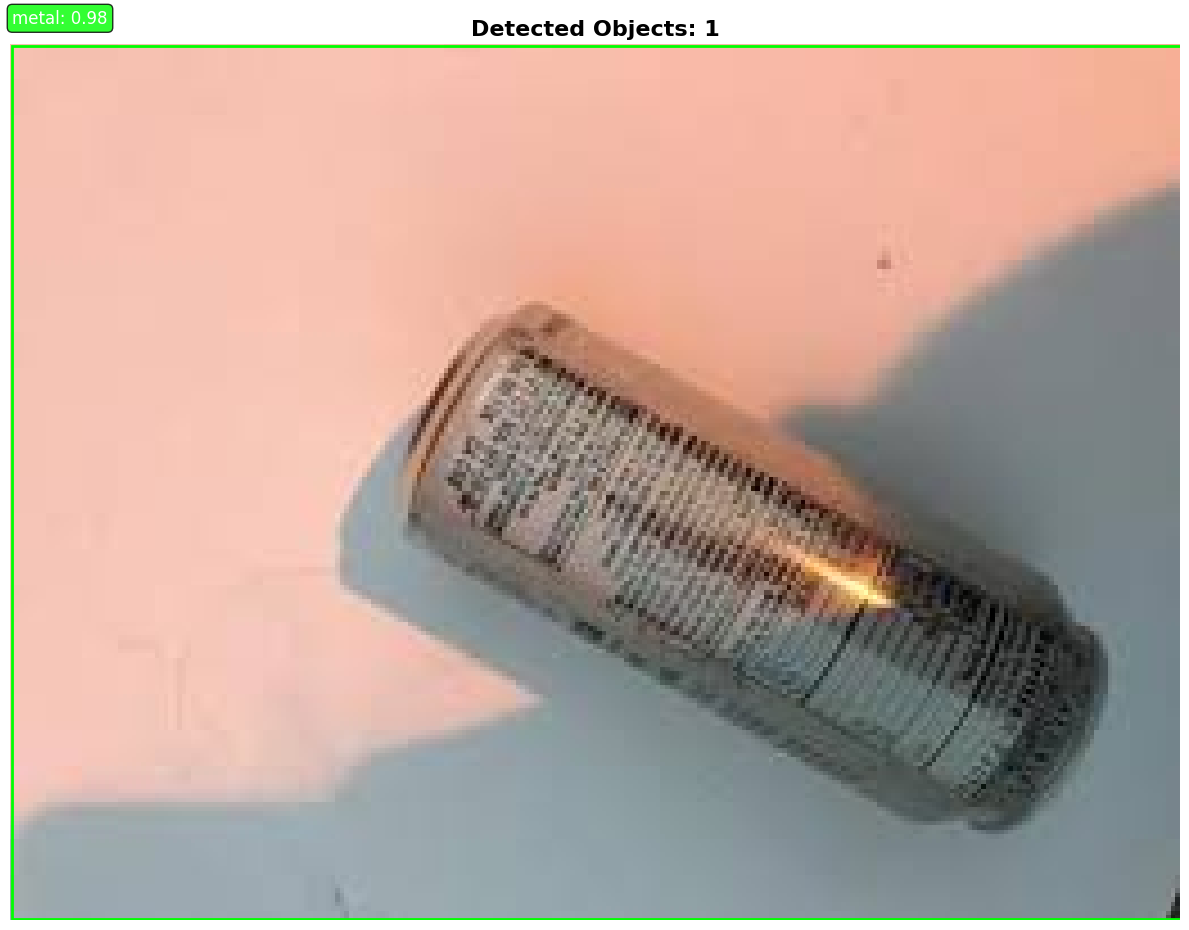

✓ Found 1 object(s)


In [10]:
# Visualize detection results with bounding boxes
def visualize_detections(image, results, confidence_threshold=0.25):
    """Display image with bounding boxes and labels."""
    if results is None or image is None:
        print("No detections to visualize")
        return
    
    # Create figure
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(image)
    
    # Get image dimensions
    img_width, img_height = image.size
    
    # Draw detections
    detection_count = 0
    
    for result in results:
        boxes = result.boxes
        
        for box in boxes:
            # Get box data
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            cls = int(box.cls[0].cpu().numpy())
            
            # Filter by confidence
            if conf < confidence_threshold:
                continue
            
            # Get class name
            class_name = result.names[cls]
            
            # Draw bounding box
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2,
                edgecolor='lime',
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # Draw label
            label = f"{class_name}: {conf:.2f}"
            ax.text(
                x1, y1 - 5,
                label,
                color='white',
                fontsize=12,
                bbox=dict(boxstyle='round', facecolor='lime', alpha=0.8)
            )
            
            detection_count += 1
    
    ax.axis('off')
    ax.set_title(f'Detected Objects: {detection_count}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    if detection_count == 0:
        print("⚠ No objects detected above confidence threshold")
    else:
        print(f"✓ Found {detection_count} object(s)")

# Visualize results
visualize_detections(uploaded_image, detection_results, confidence_threshold=0.25)

In [ ]:
# Create results table
def create_results_table(results, confidence_threshold=0.25):
    """Create a pandas DataFrame with detection results."""
    if results is None:
        print("No results to display")
        return None
    
    detections_data = []
    
    for result in results:
        boxes = result.boxes
        
        for idx, box in enumerate(boxes, 1):
            conf = box.conf[0].cpu().numpy()
            
            # Filter by confidence
            if conf < confidence_threshold:
                continue
            
            cls = int(box.cls[0].cpu().numpy())
            class_name = result.names[cls]
            
            # Get bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            
            detections_data.append({
                'Object #': idx,
                'Class': class_name,
                'Confidence': f"{conf:.3f}",
                'BBox (x1, y1, x2, y2)': f"({int(x1)}, {int(y1)}, {int(x2)}, {int(y2)})"
            })
    
    if not detections_data:
        print("⚠ No detections above confidence threshold")
        return None
    
    df = pd.DataFrame(detections_data)
    
    print("📊 Detection Results:")
    print("=" * 60)
    display(df)
    print("=" * 60)
    
    # Summary statistics
    print("\n📈 Summary:")
    print(f"  Total detections: {len(df)}")
    print("\n  Detected classes:")
    class_counts = df['Class'].value_counts()
    for class_name, count in class_counts.items():
        print(f"    - {class_name}: {count}")
    
    return df

# Display results table
results_table = create_results_table(detection_results, confidence_threshold=0.25)

SyntaxError: unexpected character after line continuation character (1788116989.py, line 45)

## Usage Instructions

1. **Upload Image**: Click the "Upload Image" button in cell 4 and select a waste image
2. **View Original**: Cell 5 displays your uploaded image
3. **Run Detection**: Cell 6 runs the YOLO model on your image
4. **View Results**: Cell 7 shows the image with bounding boxes
5. **Check Table**: Cell 8 displays detailed detection results

## Troubleshooting

- **Model not found**: Run `python train.py` first to train a model
- **No detections**: Try lowering the confidence threshold (change `0.25` to `0.15`)
- **Low performance**: Ensure GPU is available for faster inference

## Tips

- Use well-lit, clear images for best results
- Images with multiple waste items work well
- Confidence threshold of 0.25 is recommended for production use